# <center> <span style="font-family:Papyrus;"> Faster RCNN: A Gentle Introduction</span> </center>

### <center> In the persepctive of <span style="color:#b08f26">  Global Wheat Detection Competition
    

#    
![](https://images.wsj.net/im-168083?width=620&size=1.5)    


In this notebook, I will attempt to provide an introduction to Faster RNN that will be help a beginner to object detection to start applying this technology in this competition. 

### <span style="color:green"> If you find this notebook useful, please upvote. Thank you! </span>

---

###  <span style="color:#ddd"> Import Packages and Data

In [ ]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os, sys
import cv2
from IPython.display import display
plt.rcParams['figure.figsize'] = [7,5]

# Metadata 
data_df = pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')
data_df.head()

# Data path
data_path = '/kaggle/input/global-wheat-detection/train/'

## <span style="color:#b08f26">  <span style="font-family:Papyrus;"> Problem Definition </span>

The goal of this competition is **to detect wheat heads from outdoor images of wheat plants**, including wheat datasets from around the globe. 

Let's look at our inputs and outputs.

### <span style="color:green"> Input:
---

> ### ```I```: Outdoor image of wheat plant 

In [ ]:
# Read a sample image
I = cv2.cvtColor(cv2.imread(data_path + data_df.image_id[0] + '.jpg'), cv2.COLOR_BGR2RGB)
# Show the image
plt.imshow(I);
plt.axis('off')
plt.title('Wheat image')
plt.show()

### <span style="color:green">  Output:
---
> ### ```bbox```: Bounding boxes around wheat heads present in the image ```I```. 
> The format is ```[min_x_coordinate, min_y_coordinate, width, height]```
> 
> ### ```confidence```: A score that tells how confident the model is for a particular bounding box ```bbox```. 
> The value lies in ```[0,1]```.

A particular wheat image can have multiple wheat head, therefore we can have multiplte ```bbox```es. 

For example, lets draw all the ```bbox```es on the previous image.

In [ ]:
bboxes = data_df[data_df.image_id==data_df.image_id[0]].bbox.tolist()
J = I.copy()
for i in range(len(bboxes)):
    x = int(str(bboxes[i][1:-1]).split(',')[0][:-2])
    y = int(str(bboxes[i][1:-1]).split(',')[1][1:-2])
    xw = x + int(str(bboxes[i][1:-1]).split(',')[2][1:-2])
    yh = y + int(str(bboxes[i][1:-1]).split(',')[3][1:-2])
    cv2.rectangle(J,(x,y),(xw,yh),(180,190,0),4)
plt.imshow(J);
plt.axis('off')
plt.title('Wheat image bounding boxes')
plt.show()

**Note**: The training data also includes: 
- **Size of the image**: it can also be computed by ```np.shape()``` function
- **Location**: the locations from which the images were captured.

## <span style="color:green">  So what is this type of problem called?
    
Our problem can be classfied as:

> ### Binary classification and object localization problem

In particular, 

- **Classification**: We have only two classes: wheat containing images and no wheat containing images. We expect most of the images contain wheat (unless there are few exceptions).

- **Localization**: For localization, just saying it contains wheat is NOT ENOUGH. We also have to tell where those wheat heads are located in the image, i.e., localization.

 
Here is a screenshot from Stanford University School of Engineering CS231 course video (https://www.youtube.com/watch?v=nDPWywWRIRo) that shows different computer vision tasks realted to ours. Can you tell which one is most related to ours?

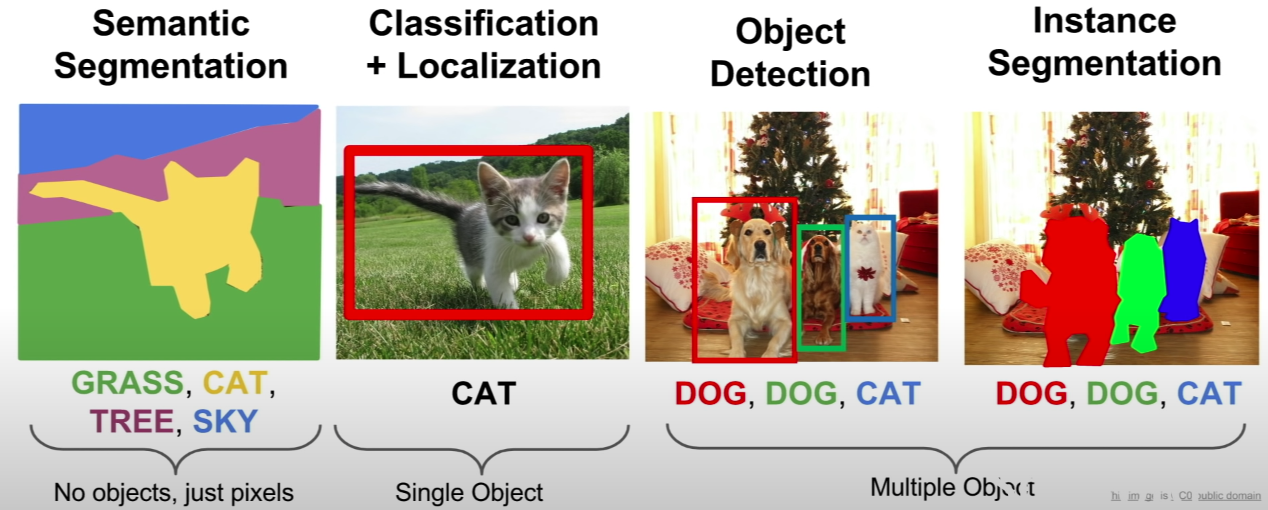


### Therefore, we need to find a technology that can:
1. Tell if our input image contains wheat heads,
2. If there are wheat heads, where are they located?
3. It has to draw bounding boxes around the located objects (i.e., wheat heads), and 
4. Tell us how confident the algorithm is that it is wheat head?

## <span style="font-family:Papyrus;"> What is Faster RCNN?  </span>

Faster RCNN is a technology that can provide answers the questions we asked above. How? 

Before answering it, I will provide a brief background to its predecessors. This will help you to understand why it is so popular.

## <span style="color:green"> Background

Faster RCNN belongs to region-based object detection methods. 

The journey to the development of Faster RCNN followed this path:

1. **2014**: In the original [paper](https://arxiv.org/pdf/1311.2524.pdf), Ross Girshick et al. proposed Regions with CNN features (RCNN).

2. **2015**: Girshick improved RCNN, and proposed Fast RCNN in this original [paper](https://arxiv.org/pdf/1504.08083.pdf).

3. **2015**: Finally, this [paper](http://arxiv.org/abs/1506.01497) improved upon Fast RCNN and proposed Faster RCNN!

Let's quickly overview each of them!

### Model 1: RCNN

This is the architecture of RCNN:


![](https://storage.googleapis.com/kagglesdsdata/datasets/638003/1133328/rcnn1.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1588991839&Signature=EwsVfQaUPuC%2FxHBlbwPFDfSBbmOumh6L9xRp8V%2B8A7m60%2BtWw4%2BIZQi6UXuAjzVCrVSPrn5jKfQ7aAWjqOd9jFShfNG%2Bp4EczhB64aStAGYedCisCii2a2gZjwv4kKTFMkExUXJzxizLwwce2ICr%2B7I2tIKImvzctrx4FlGqonwUxLRFyr97hcstVdgD9V5kXdfd513xmrcTLqeuh5zt7VWic28qkk%2F3tJSlZqrdE6B4K8Z14Rmn6W%2BrXFLx9Mol%2FNN6h8NuPsIRCxwM1eb4yjq3reCqf7YNFOFZM3wfTTWLLEkRbhRI8UlLnW1S3BvrFEziqOnA3bUzGBFAl29CZA%3D%3D)

![](https://www.learnopencv.com/wp-content/uploads/2019/06/rcnn.png)

#### <center> *(Images from Stanford and learnopencv.com)*



**Step 1**: They used an algorithm called Selective Search to detect 2000 region proposals. This proposes the regions that could be potential objects.

**Step 2**: They ran a CNN + SVM based image classifier on these 2000 bounding boxes.

####  <span style="color:orange"> Verdict:
The accuracy of R-CNN at that time was the state of the art, but the speed was still very slow. 
- Inference takes 18-20 seconds per image on a GPU
- Training was slow (84 hour) and takes lot of disk space
- Adhoc training objectives for region proposal and SVM


### Model 2: Fast RCNN

This is the architecture of Fast RCNN:


![](https://storage.googleapis.com/kagglesdsdata/datasets/638003/1133365/fast-rcnn.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1588992630&Signature=GOSw5nVWxWEDijlYuDjWJaLC4TQ2t%2F9fjcWCyxhDMnj6zwBnxoQzk%2B%2BTHLcRiw%2Ba%2BmRJugVGSuekV2JvGFU2Mker9kTWYs4KZzNCj%2F09O55zX2hk8SXCnFCqXnb2B0jnIZnprkS66zs80jYqkvXo2XQ8qf28kUqAByY9GnxqZ9AlbtYyiMn5x5u%2BP2kfYovVxL%2BeSN8kBa7QIIRzLn4QVWhvSHOlaiwvdLrlouoKW%2BslgluA2Z3riYYYdUoOoVxuJhT7no4Lxg3tmv5bWLWcX9LvsYe%2BJDCW5nOwzygQpHbdmezaLHXayUNSKQyAZ9fKjhhkqYVhS9UhP08qvi2%2B2w%3D%3D)

![](https://www.learnopencv.com/wp-content/uploads/2019/06/frcnn.png)

#### <center> *(Images from Stanford and learnopencv.com)*

In Fast RCNN, instead of feeding 2000 region proposals separately to different convlution neural networks, now estimated region proposals (not necessarily 2000) are combined to a feature map and fed to a single neural network.

####  <span style="color:orange"> Verdict:
Fast RCNN achieved a great performance boost.

![](https://storage.googleapis.com/kagglesdsdata/datasets/638003/1133386/fastrcnn-performance.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1588993106&Signature=gpSbM560XcmkRoyRqx0p8%2FrTV8Y0m2%2FtJ96yZy%2Bjcw1%2F%2FdzInxcrdAlJahnAeahZbzou9B7Mx76fGsYkcsET490DKxChG%2BJbTjJvy11sLlhWmgwZHEHJftwYnSQJqbW3%2B%2FIDn4980NFw%2BNHF59dHMePSjJ%2Bmmtkd3HTzv54qKkBccHCm83wUeO2z9eqWFKTcmYNH71JHAJnwVUDioh73McusN6ZaF71l%2FeP5iRxWweknPjGLaTZwmrO4IhW4U04kxIohTPh7UWjuDgLmr5C%2BNvN2gDI90J16M0GFvdYLfBdf9PTBYC6SzQnguL3pY%2BjpJQs7kqLY9qhnN%2FqtiRmDQQ%3D%3D)
#### <center> *(Images from Stanford)*

### Model 3: Faster RCNN

This is the architecture of Faster RCNN:

![](https://storage.googleapis.com/kagglesdsdata/datasets/638003/1133437/fasterrcnn.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1588995574&Signature=iMvUbG3g7Ck2fNErU8MgqCXGqzxMnYUO%2B%2F%2Bj5xyy1%2FLW3Brmkh6gfFMJEuDH%2FcPkOf9aIhYHs4tFes9ZX4BDaZXF2fkp%2Frb%2BxXET%2FS2CljZd9v%2BPVkcDOPUMm41jLr8okNDDu1yDxU%2F1vgCrAddup01gwW8%2FxjiyQIG3AYGG3b%2Fjm4Xr019EAKLfD%2B4vd%2FjOQ13c7o%2FI0geKwE916P0GDaIjuLO3TraqkDaVP%2BDpb%2Fy56jw6S%2FFN82%2BonaqPu%2FSh1f88c%2F%2BwPnYD22SIJ7tONIm2CFI2URrnVI5N%2FKbQltSmrLWs%2BgAa1Dp7Fcq5xXhV1i3YIiUUaeLBd39BRzVBbQ%3D%3D)


A Convolutional Neural Network was used to produce a feature map of the image which was simultaneously used for training a region proposal network and an image classifier. Because of this shared computation, there was a significant improvement in the speed of object detection.

####  <span style="color:orange"> Verdict:
    
Faster RCNN revolutionized object detection. Now inference can be done in less than a second, although training time is higher than Fast RCNN.

![](https://storage.googleapis.com/kagglesdsdata/datasets/638003/1133441/faster-rcnn-perf.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1588995836&Signature=pfd5oAjlM6KGlKvA4W4ZJrYAtP09Eg7PjYYNOCjUO6OBFIL1kVBcOBvgedULinuSTt0kY%2FB7d%2B8ALWDkvV%2FbVeaUU5QL5LhzMWzhyWcdHu9M%2BNFqivktRCg5RoYFbuNzWlDUCuogYc41KYQ4Zil2sQGXQZe52OZwdRRlTUXJ0NGa5Ji86tKxh8MbcjVAnztXqPaJzPbEAHro%2BR9eJND80afr3wEfRimaxsHfv%2BWY6m%2BBBzWpC4DgOGogAMXXBADnHOSQeD0%2Fgh%2BkHjknmPiV7X4ruI8oiEom67yX6AMT8v8V31COYNdQfB5mtN0KIkPXHfXQ1wZ1vxUotMj5l8m5HA%3D%3D)

### Overall:

![](https://dzone.com/storage/temp/9814919-screen-shot-2018-07-23-at-114334-am.png)


## <span style="font-family:Papyrus;"> How can we use Faster RCNN in this competition? </span>

We can perform transfer learning with a pretrained faster RCNN model. You can load the pretrained (pre-trained on COCO train2017) model using ```torchvision.model```.

In [ ]:
import torchvision
base_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

We can then replace the pre-trained head.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = base_model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Training

For more on how to train, I suggest look at the kernel by @pestipeti https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

Thank you! I hope this discussion was useful.

## References

- https://github.com/rbgirshick/py-faster-rcnn
- http://arxiv.org/abs/1506.01497
- https://papers.nips.cc/paper/5638-faster-r-cnn-towards-real-time-object-detection-with-region-proposal-networks